# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [7]:
!pip install torch torchvision

In [8]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=4e14fa627acb6aa51267cea345f9042d3b47e0cb01c67065dfe9be4080ef4b3a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 158.6 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


In [9]:
!nvidia-smi

Thu Feb 27 12:15:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distributions involved. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 15
learning_rate  =  0.001 #@param
batch_size = 128
### Choose a value for the size of the latent space
latent_dim = 20 #@param
intermediate_layer_size = 400 #@param

###

# Define here the any extra hyperparameters you used.
beta = 1.5 #@param

###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
    #  transforms.Normalize(),
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

def denorm(x):
  return x.view(-1,1,28,28)



## Data loading


In [12]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Model Definition

In [13]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.linear1 = nn.Linear(784, intermediate_layer_size)
        self.linear_mean = nn.Linear(intermediate_layer_size, latent_dim)
        self.linear_logvar = nn.Linear(intermediate_layer_size, latent_dim)
        self.linear3 = nn.Linear(latent_dim, intermediate_layer_size)
        self.linear4 = nn.Linear(intermediate_layer_size, 784)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = F.relu(self.linear1(x))
        mean = self.linear_mean(x)
        logvar = self.linear_logvar(x)
        return mean, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = F.relu(self.linear3(z))
        x = self.linear4(x)
        x = F.sigmoid(x)
        return x
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mean, logvar = self.encode(x.view(-1, 784))
        latent_vector = self.reparametrize(mean, logvar)
        output = self.decode(latent_vector)
        return output, mean, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 652824
VAE(
  (linear1): Linear(in_features=784, out_features=400, bias=True)
  (linear_mean): Linear(in_features=400, out_features=20, bias=True)
  (linear_logvar): Linear(in_features=400, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=400, bias=True)
  (linear4): Linear(in_features=400, out_features=784, bias=True)
)


## Training loop

In [14]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(reconstructed_data, input_data, mean, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        reconstruction_loss = F.binary_cross_entropy(reconstructed_data, input_data.view(-1, 784), reduction='sum')

        kl_divergence = -0.5 * torch.sum(1 + logvar - (mean.pow(2)) - logvar.exp())

        loss = reconstruction_loss + beta * kl_divergence

        return (loss, kl_divergence, reconstruction_loss)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model.train()
kl_losses_train = []
reconstruction_losses_train = []
total_losses_train = []
kl_losses_test = []
reconstruction_losses_test = []
total_losses_test = []
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        model.train()
        train_loss = 0
        kl = 0
        rec = 0
        for batch_idx, (data, _) in enumerate(loader_train):
            data = data.to(device)
            optimizer.zero_grad()
            generated_images, mean, logvar = model(data)
            loss = loss_function_VAE(generated_images, data, mean, logvar)
            total_loss = loss[0]
            kl_div = loss[1]
            rec_loss = loss[2]
            (total_loss / len(data)).backward()
            train_loss += total_loss
            kl += kl_div
            rec += rec_loss
            optimizer.step()

            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader_train.dataset),
                    100. * batch_idx / len(loader_train),
                    total_loss / len(data)))

        av_tot_loss = train_loss / len(loader_train.dataset)
        av_kl = kl / len(loader_train.dataset)
        av_rec = rec / len(loader_train.dataset)
        kl_losses_train.append(av_kl)
        reconstruction_losses_train.append(av_rec)
        total_losses_train.append(av_tot_loss)
        print('====> Epoch: {} Average loss: {:.4f} rec: {:.4f} KL: {:.4f}'.format(
              epoch, av_tot_loss, av_rec, av_kl))
        
        




        model.eval()
        test_loss = 0
        kl = 0
        rec = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(loader_test):
                data = data.to(device)
                generated_images, mean, logvar = model(data)
                loss = loss_function_VAE(generated_images, data, mean, logvar)
                total_loss = loss[0]
                kl_div = loss[1]
                rec_loss = loss[2]
                test_loss += total_loss
                kl += kl_div
                rec += rec_loss
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                          generated_images.view(batch_size, 1, 28, 28)[:n]])
                    save_image(comparison.cpu(),
                            './reconstruction_' + str(epoch) + '.png', nrow=n)

        av_tot_loss = test_loss / len(loader_test.dataset)
        av_kl = kl / len(loader_test.dataset)
        av_rec = rec / len(loader_test.dataset)
        kl_losses_test.append(av_kl)
        reconstruction_losses_test.append(av_rec)
        total_losses_test.append(av_tot_loss)
        print('====> Test set loss: {:.4f}'.format(av_tot_loss))

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 550.978699
Train Epoch: 0 [1280/60000 (2%)]	Loss: 311.096924
Train Epoch: 0 [2560/60000 (4%)]	Loss: 229.414078
Train Epoch: 0 [3840/60000 (6%)]	Loss: 223.431290
Train Epoch: 0 [5120/60000 (9%)]	Loss: 209.298462
Train Epoch: 0 [6400/60000 (11%)]	Loss: 217.082855
Train Epoch: 0 [7680/60000 (13%)]	Loss: 208.372498
Train Epoch: 0 [8960/60000 (15%)]	Loss: 196.837708
Train Epoch: 0 [10240/60000 (17%)]	Loss: 195.502457
Train Epoch: 0 [11520/60000 (19%)]	Loss: 193.117950
Train Epoch: 0 [12800/60000 (21%)]	Loss: 187.300873
Train Epoch: 0 [14080/60000 (23%)]	Loss: 182.787445
Train Epoch: 0 [15360/60000 (26%)]	Loss: 177.686890
Train Epoch: 0 [16640/60000 (28%)]	Loss: 178.401901
Train Epoch: 0 [17920/60000 (30%)]	Loss: 179.055878
Train Epoch: 0 [19200/60000 (32%)]	Loss: 177.390717
Train Epoch: 0 [20480/60000 (34%)]	Loss: 169.995560
Train Epoch: 0 [21760/60000 (36%)]	Loss: 166.853241
Train Epoch: 0 [23040/60000 (38%)]	Loss: 166.819824
Train Epoch: 0 [24320/60000 

### Your explanations about the loss function here:

Reconstruction loss: 
I decided to use the binary cross entropy function due to the fact that I use a sigmoid activation function to generate the reconstructed output, which can be seen as a bernoulli distribution. Furthermore, the MNIST dataset I use also has pixel intensities between 0 and 1. Therefore binary cross entropy is a suitable loss function to quantitatively measure the difference between the reconstruction and the original image. 

KL divergence:
I used the standard KL divergence loss term, but upscaled it by a factor of beta in order to improve disentanglement in the latent space  as described by Higgins et. al's paper on the beta-VAE. This means that different classes of numbers overlap less and are therefore more distinct from each other during reconstruction. However, this also makes the final reconstructions blurrier as upscaling the KL divergence also reduces the flexibility of the posterior distribution. 

## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


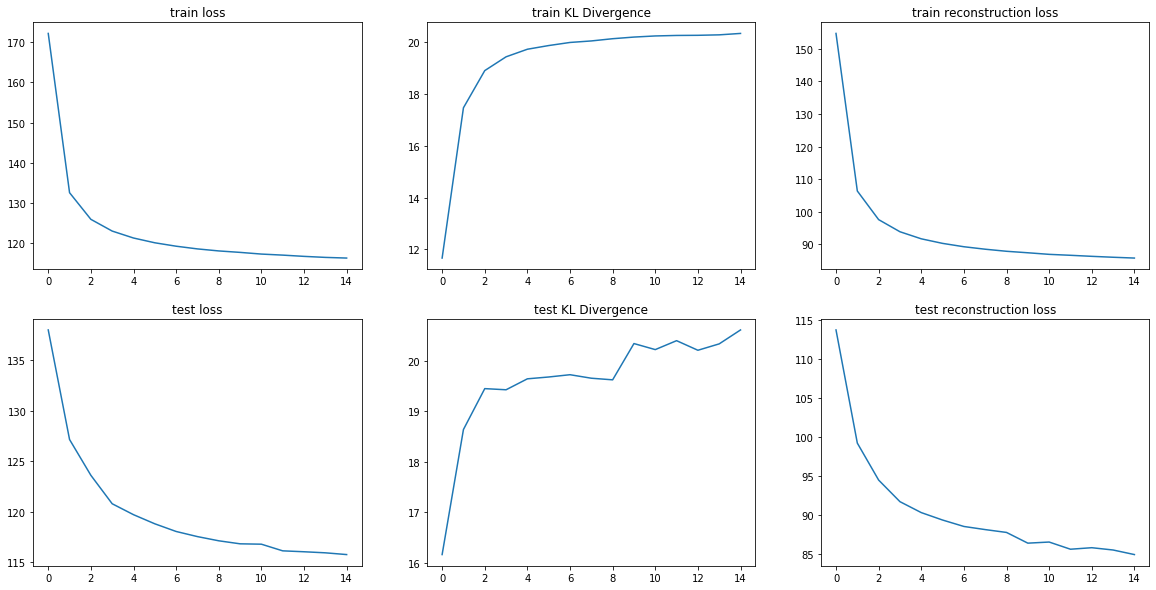

In [15]:
# *CODE FOR PART 1.2a IN THIS CELL*
epochs = range(num_epochs)

plt.figure(figsize=(20,10))

plt.subplot(231)
plt.plot(epochs, total_losses_train)
plt.title('train loss')

plt.subplot(232)
plt.plot(epochs, kl_losses_train)
plt.title('train KL Divergence')

plt.subplot(233)
plt.plot(epochs, reconstruction_losses_train)
plt.title('train reconstruction loss')

plt.subplot(234)
plt.plot(epochs, total_losses_test)
plt.title('test loss')

plt.subplot(235)
plt.plot(epochs, kl_losses_test)
plt.title('test KL Divergence')

plt.subplot(236)
plt.plot(epochs, reconstruction_losses_test)
plt.title('test reconstruction loss')


plt.show()

### Your answer to 1.2b here:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


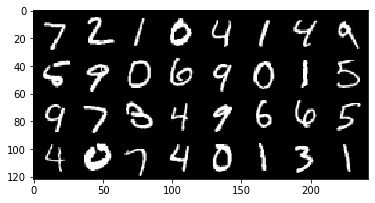

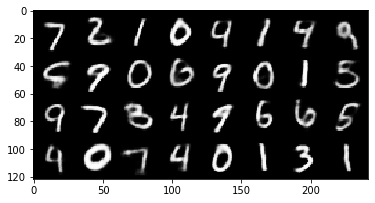

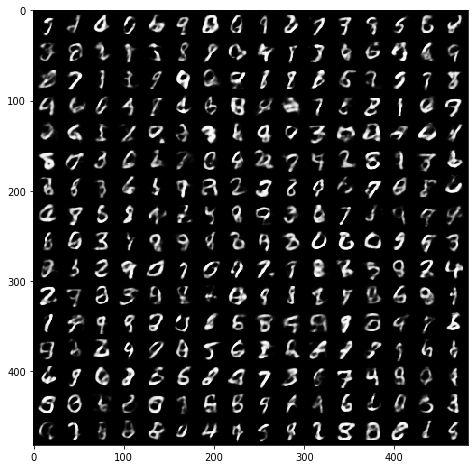

In [16]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, mean, logvar = model.forward(fixed_input.view(fixed_input.size(0), -1).to(device))
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

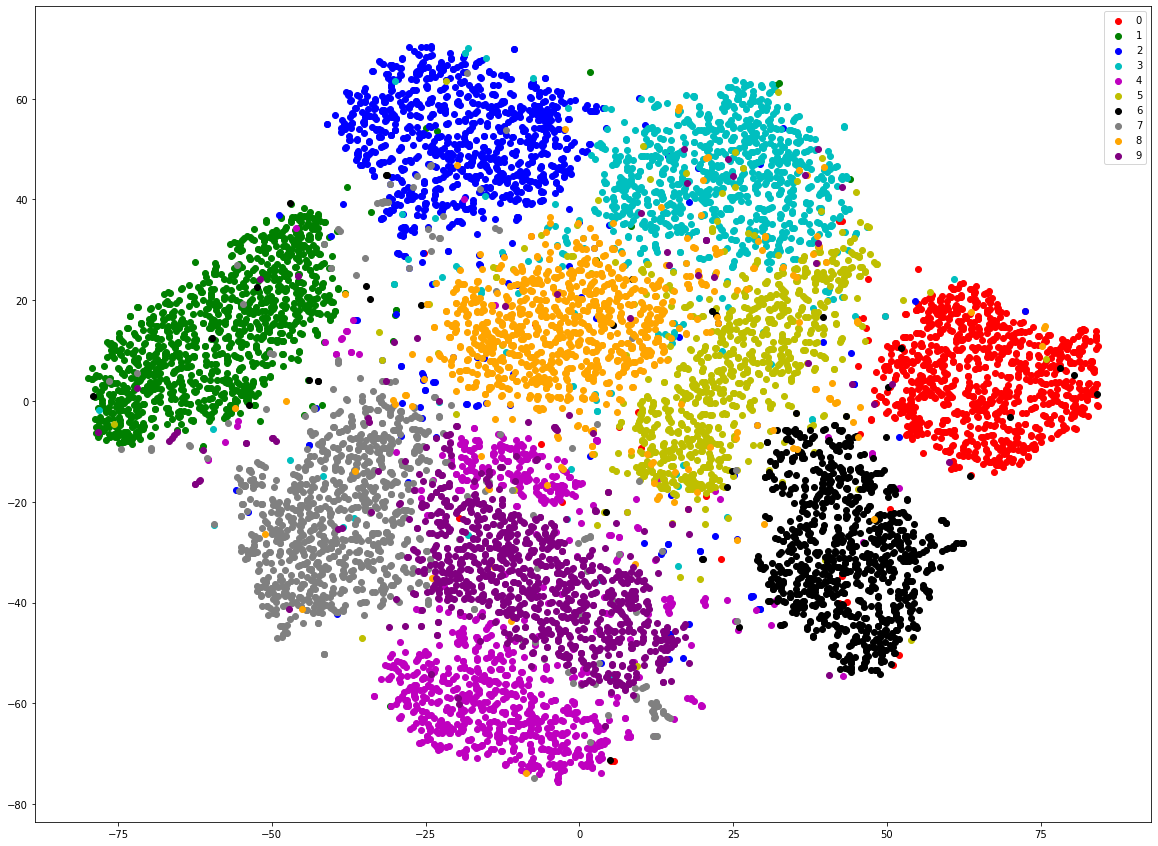

In [17]:
import sklearn.manifold

# *CODE FOR PART 1.3a IN THIS CELL*
sample_inputs, _ = next(iter(loader_test))

# X = sample_inputs.view(sample_inputs.size(0),-1)
# tsne = sklearn.manifold.TSNE(n_components = 2, random_state=0).fit_transform(X)

test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_test = DataLoader(test_dat, len(test_dat), shuffle=False)

X, y = next(iter(loader_test))

model.eval()
mu, logvar = model.encode(X.view(X.size(0), -1).to(device))

recon_batch = model.reparametrize(mu, logvar)

tsne = sklearn.manifold.TSNE(n_components = 2, random_state=0).fit_transform(recon_batch.detach().cpu())

target_ids = range(10)

plt.figure(figsize = (20,15))
colors = 'r','g','b','c','m','y','k','#808080','orange','purple'
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(tsne[y == i, 0], tsne[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

### Your answer to 1.3a here:

Within the tsne representation, you can observe that each digit class generally has its own distinct area of the latent space.There are some overlaps, due to the diversity of the hand written digits in MNIST, but there are only a few of these outliers. visually similar digits such as 1 and 7 and 0 and 8 are close to each other, while digits that are different sucg as 0 and 1 are far away.

From the experiments that I have conducted, this is the most favorable latent representation. A tighter representation leads to more overlap between different classes and reduces the network's ability to effectively produce distinct and diverse reconstructions. 

torch.Size([1, 20])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


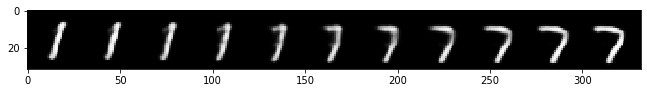

In [18]:
# *CODE FOR PART 1.3b IN THIS CELL*
def interpolate(z1, z2, num=11):
    Z = np.zeros((z1.shape[0], num))
    Z = []
    for i in range(z1.shape[0]):
        Z.append(np.linspace(z1[i], z2[i], num))
    Z = np.array(Z)
    return Z


digit1 = X[y == 1][1,:,:]
digit2 = X[y == 7][1,:,:]
mu1, logvar1 = model.encode(digit1.view(digit1.size(0),-1).to(device))
centroid1 = model.reparametrize(mu1, logvar1)
mu2, logvar2 = model.encode(digit2.view(digit2.size(0),-1).to(device))
centroid2 = model.reparametrize(mu2, logvar2)
print(centroid1.shape)
interpolation = interpolate(centroid1.detach().to('cpu'), centroid2.detach().to('cpu'))

out = model.decode(torch.Tensor(interpolation).to(device)).view(-1,1,28,28)

out = make_grid(out, nrow=11, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (11,11))
show(out.detach().to('cpu'))

### Your answer to 1.3b here:

As mentioned in section 1.3a, visually similar digits are closely distributed in the latent space. Therefore, interpolating between two visually similar digits such as 1 and 7 shows a smooth transition from 1 to 7. 

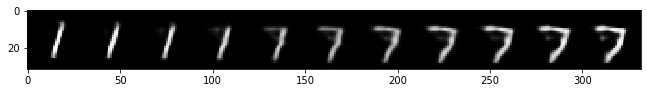

However, if you interpolate between digits that are spaced further apart from each other in the latent space (such as 1 and 0), you can see that the interpolation crosses the latent representations for other numbers such as 8 and 5, which can be recognized in the interpolation. 

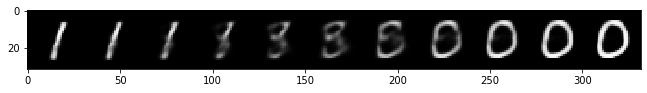

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')



cuda:0


### Data loading

In [20]:
batch_size = 64
NUM_TRAIN = 49000



transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*


### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 100
learning_rate  = 0.0002 # optimum from paper = 0.0002
latent_vector_size = 100
###

# Define here other hyperparameters that you used.

num_channels = 3
generator_depth = 128
discriminator_depth = 64


In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*



class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.tconv1 = nn.ConvTranspose2d(latent_vector_size, generator_depth * 4, 4, 1, 0, bias = False)
        self.batchnorm1 = nn.BatchNorm2d(generator_depth * 4)
        self.tconv2 = nn.ConvTranspose2d(generator_depth * 4, generator_depth * 2, 4, 2, 1, bias = False)
        self.batchnorm2 = nn.BatchNorm2d(generator_depth * 2)
        self.tconv3 = nn.ConvTranspose2d(generator_depth * 2, generator_depth, 4, 2, 1, bias = False)
        self.batchnorm3 = nn.BatchNorm2d(generator_depth)
        self.tconv4 = nn.ConvTranspose2d(generator_depth, num_channels, 4, 2, 1, bias = False)
        self.batchnorm4 = nn.BatchNorm2d(num_channels)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.batchnorm1(self.tconv1(z))
        x = F.relu(x)
        x = self.batchnorm2(self.tconv2(x))
        x = F.relu(x)
        x = self.batchnorm3(self.tconv3(x))
        x = F.relu(x)
        x = self.batchnorm4(self.tconv4(x))
        x = F.tanh(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.conv1 = nn.Conv2d(num_channels, discriminator_depth, 4, 2, 1, bias=False)
        #no batchnorm 1st layer
        self.conv2 = nn.Conv2d(discriminator_depth, discriminator_depth * 2, 4, 2, 1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(discriminator_depth * 2)
        self.conv3 = nn.Conv2d(discriminator_depth * 2, discriminator_depth * 4, 4, 2, 1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(discriminator_depth * 4)
        self.conv4 = nn.Conv2d(discriminator_depth * 4, 1, 4, 1, 0, bias=False)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.conv1(x)
        out = F.leaky_relu(out, negative_slope=0.2)
        out = self.batchnorm2(self.conv2(out))
        out = F.leaky_relu(out, negative_slope=0.2)
        out = self.batchnorm3(self.conv3(out))
        out = F.leaky_relu(out, negative_slope=0.2)
        out = self.conv4(out)
        out = F.sigmoid(out)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [64]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3448582
Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Total number of parameters in Discriminator is: 663296
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss



### Choose and initialize optimizers

In [0]:
# setup optimizer

# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0



### Train

In [0]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/100][0/766] Loss_D: 1.6410 Loss_G: 2.0020 D(x): 0.4187 D(G(z)): 0.4536 / 0.1547
[0/100][1/766] Loss_D: 1.9125 Loss_G: 1.5580 D(x): 0.6092 D(G(z)): 0.7074 / 0.2397
[0/100][2/766] Loss_D: 2.2865 Loss_G: 1.5019 D(x): 0.5854 D(G(z)): 0.7826 / 0.2562
[0/100][3/766] Loss_D: 1.9515 Loss_G: 2.0557 D(x): 0.5734 D(G(z)): 0.7115 / 0.1443
[0/100][4/766] Loss_D: 1.6466 Loss_G: 2.4546 D(x): 0.5777 D(G(z)): 0.6092 / 0.1012
[0/100][5/766] Loss_D: 1.7721 Loss_G: 2.5476 D(x): 0.4795 D(G(z)): 0.5733 / 0.0919
[0/100][6/766] Loss_D: 1.6846 Loss_G: 2.7473 D(x): 0.5372 D(G(z)): 0.5878 / 0.0759
[0/100][7/766] Loss_D: 1.3728 Loss_G: 3.1840 D(x): 0.5767 D(G(z)): 0.5117 / 0.0480
[0/100][8/766] Loss_D: 1.3787 Loss_G: 3.3487 D(x): 0.5691 D(G(z)): 0.4964 / 0.0410
[0/100][9/766] Loss_D: 1.5189 Loss_G: 3.4081 D(x): 0.5639 D(G(z)): 0.5237 / 0.0406
[0/100][10/766] Loss_D: 1.3685 Loss_G: 3.7155 D(x): 0.6287 D(G(z)): 0.5417 / 0.0275
[0/100][11/766] Loss_D: 1.5676 Loss_G: 3.9797 D(x): 0.6225 D(G(z)): 0.5966 / 0.0235
[0

# DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL*

I restricted my choice of architecture to the guidelines in the original DCGAN paper, which are as follows:


    Replace any pooling layers with strided convolutions in the discriminator and fractional-strided convolutions in the generator
    Use Batch Normalization in the generator and discriminator
    Remove fully connected hidden layers for deeper architectures
    Use ReLU activation in generator for al layers except for Tanh in output (These images are normalized between [-1, 1] rather than [0,1] , thus Tanh over sigmoid)
    Use LeakyReLU activation in the discriminator for all layers

A further recommendation by the paper (though not a guideline) was that a lr of 0.0002 gives the best results along with an adam optimizer. 

Thus, my choices were restricted to the number of convolutional layers, the size of each layer, and the size of the latent space. 
I set up architecture in a cascading style that reduces the depth of its convolutional layers by 2 every layer with 4 convolutional layers in both the discriminator and generator. I could use two numbers, one for the discriminator and one for the generator to specify the relative sizes of the two and easily change their capacity. 


### Generator samples

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

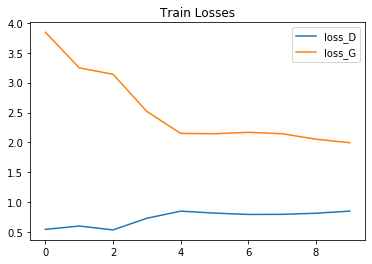

In [46]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

In [0]:
# ANSWER FOR PART 2.2 IN THIS CELL*
The plot looks reasonable. The Generator error starts low since the discriminator i

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

# ANSWER FOR PART 2.3 IN THIS CELL*

Mode collapse never seemed to be a problem during any of my experiments, unless I forced it to happen by for example decreasing the size of the latent space to 1. Mode collapse generally occurs when the generator is only capable of producing a few modes, which manifests as most of the images looking similar. This happens either when the generator is incapable of producing more modes (which is what happens when you reduce the latent space too much) or when the generator gets a head start on the discriminator in the training process, and realizes that it can fool the discriminator with a specific type of image. When the discriminator identifies this image type as a fake, the generator simply shifts to the next local mode. 